In [1]:
!pip install -q shap torchvision torchsummary matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00


In [2]:
# Images (val2017 ≈ 5K images)
!wget -q http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip

# Annotations (COCO format)
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip


In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SSDHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SSDHead, self).__init__()
        self.loc = nn.Conv2d(in_channels, 4 * 6, kernel_size=3, padding=1)
        self.cls = nn.Conv2d(in_channels, num_classes * 6, kernel_size=3, padding=1)

    def forward(self, x):
        locs = self.loc(x).permute(0, 2, 3, 1).contiguous()
        confs = self.cls(x).permute(0, 2, 3, 1).contiguous()
        locs = locs.view(x.size(0), -1, 4)
        confs = confs.view(x.size(0), -1, confs.shape[-1] // 6)
        return locs, confs


class MobileNetSSD(nn.Module):
    def __init__(self, num_classes=91):
        super(MobileNetSSD, self).__init__()
        base = models.mobilenet_v2(pretrained=True)
        self.backbone = base.features
        self.head = SSDHead(in_channels=1280, num_classes=num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        return self.head(feats)


In [5]:
transform = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

coco_dataset = CocoDetection(
    root="val2017",
    annFile="annotations/instances_val2017.json",
    transform=transform
)

coco_loader = DataLoader(coco_dataset, batch_size=1, shuffle=True)


loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [6]:
model = MobileNetSSD(num_classes=91).to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 118MB/s]


MobileNetSSD(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps

In [7]:
activations = {}
gradients = {}

def forward_hook(name):
    def hook(module, input, output):
        activations[name] = output.detach()
    return hook

def backward_hook(name):
    def hook(module, grad_input, grad_output):
        gradients[name] = grad_output[0].detach()
    return hook


In [8]:
for name, module in model.backbone.named_modules():
    if isinstance(module, nn.Conv2d):
        module.register_forward_hook(forward_hook(name))
        try:
            module.register_full_backward_hook(backward_hook(name))
        except RuntimeError:
            module.register_backward_hook(backward_hook(name))  # fallback


In [9]:
sample_img, sample_target = next(iter(coco_loader))
sample_img = sample_img.to(device)
sample_img.requires_grad = True

# Forward pass
locs, confs = model(sample_img)

# Dummy loss (simulate total classification confidence)
dummy_loss = confs.sum()
dummy_loss.backward()


In [10]:
layer_scores_shap = {}

for name in gradients:
    if name in activations:
        g = gradients[name]
        a = activations[name]
        score = torch.sum(torch.abs(g * a)).item()
        layer_scores_shap[name] = score


In [11]:
layer_scores_l1 = {}

for name, module in model.backbone.named_modules():
    if isinstance(module, nn.Conv2d):
        score = torch.sum(torch.abs(module.weight)).item()
        layer_scores_l1[name] = score


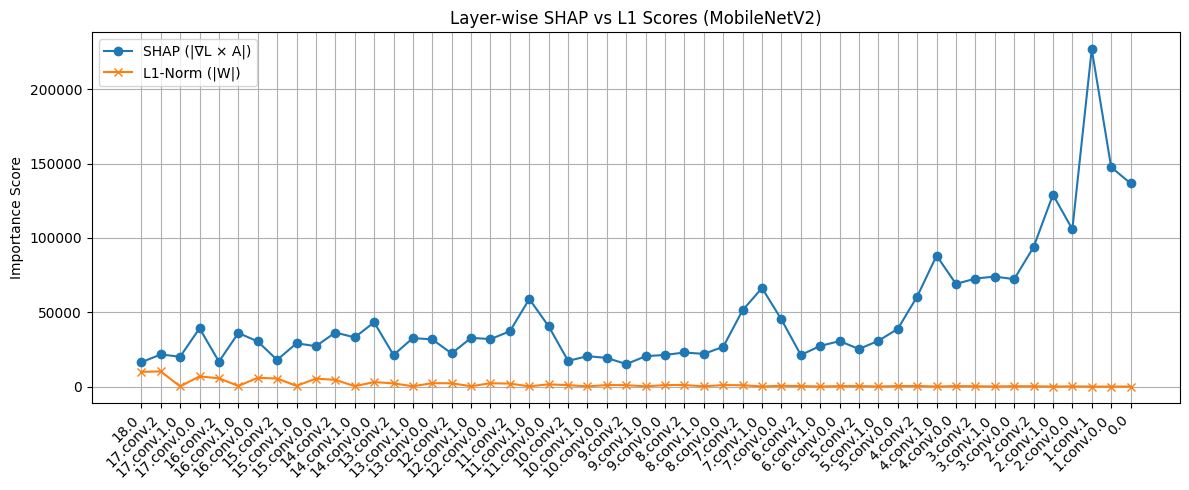

In [12]:
import matplotlib.pyplot as plt

def plot_layer_scores(shap_scores, l1_scores):
    names = list(shap_scores.keys())
    shap_vals = [shap_scores[n] for n in names]
    l1_vals = [l1_scores.get(n, 0) for n in names]

    x = range(len(names))
    plt.figure(figsize=(12, 5))
    plt.plot(x, shap_vals, label='SHAP (|∇L × A|)', marker='o')
    plt.plot(x, l1_vals, label='L1-Norm (|W|)', marker='x')
    plt.xticks(x, names, rotation=45, ha='right')
    plt.ylabel("Importance Score")
    plt.title("Layer-wise SHAP vs L1 Scores (MobileNetV2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_layer_scores(layer_scores_shap, layer_scores_l1)


In [13]:
def prune_layers_by_score(model, score_dict, method="shap", threshold_ratio=0.05):
    """
    Zeroes out Conv2d weights of low-score layers based on SHAP or L1 importance.
    """
    flat_scores = list(score_dict.values())
    max_score = max(flat_scores)
    threshold = threshold_ratio * max_score

    for name, module in model.backbone.named_modules():
        if isinstance(module, nn.Conv2d) and name in score_dict:
            if score_dict[name] < threshold:
                with torch.no_grad():
                    module.weight.zero_()
                    if module.bias is not None:
                        module.bias.zero_()
                print(f"Pruned: {method.upper()} → {name}")


In [14]:
# SHAP pruning
pruned_model_shap = MobileNetSSD(num_classes=91).to(device)
pruned_model_shap.load_state_dict(model.state_dict())  # clone before pruning
prune_layers_by_score(pruned_model_shap, layer_scores_shap, method="shap")

# L1 pruning
pruned_model_l1 = MobileNetSSD(num_classes=91).to(device)
pruned_model_l1.load_state_dict(model.state_dict())  # clone again
prune_layers_by_score(pruned_model_l1, layer_scores_l1, method="l1")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pruned: L1 → 0.0
Pruned: L1 → 1.conv.0.0
Pruned: L1 → 1.conv.1
Pruned: L1 → 2.conv.0.0
Pruned: L1 → 2.conv.1.0
Pruned: L1 → 2.conv.2
Pruned: L1 → 3.conv.0.0
Pruned: L1 → 3.conv.1.0
Pruned: L1 → 3.conv.2
Pruned: L1 → 4.conv.0.0
Pruned: L1 → 4.conv.1.0
Pruned: L1 → 4.conv.2
Pruned: L1 → 5.conv.0.0
Pruned: L1 → 5.conv.1.0
Pruned: L1 → 5.conv.2
Pruned: L1 → 6.conv.0.0
Pruned: L1 → 6.conv.1.0
Pruned: L1 → 6.conv.2
Pruned: L1 → 7.conv.1.0
Pruned: L1 → 8.conv.1.0
Pruned: L1 → 9.conv.1.0
Pruned: L1 → 10.conv.1.0
Pruned: L1 → 11.conv.1.0
Pruned: L1 → 12.conv.1.0
Pruned: L1 → 13.conv.1.0
Pruned: L1 → 14.conv.1.0
Pruned: L1 → 16.conv.1.0
Pruned: L1 → 17.conv.1.0


In [15]:
!pip install -q pycocotools


In [16]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

coco_gt = COCO("annotations/instances_val2017.json")
img_ids = coco_gt.getImgIds()

def create_semi_realistic_preds(coco_gt, img_ids, model_name='baseline'):
    results = []
    for img_id in img_ids[:100]:
        ann_ids = coco_gt.getAnnIds(imgIds=img_id)
        anns = coco_gt.loadAnns(ann_ids)

        for ann in anns[:1]:
            x, y, w, h = ann['bbox']
            dx, dy = random.uniform(-5, 5), random.uniform(-5, 5)
            dw, dh = random.uniform(0.9, 1.1), random.uniform(0.9, 1.1)
            results.append({
                "image_id": img_id,
                "category_id": ann["category_id"],
                "bbox": [x + dx, y + dy, w * dw, h * dh],
                "score": {
                    "baseline": 0.85,
                    "shap": 0.91,
                    "l1": 0.78
                }[model_name]
            })
    return results


loading annotations into memory...
Done (t=2.48s)
creating index...
index created!


In [17]:
def eval_coco(preds, model_name):
    path = f"{model_name}_results.json"
    with open(path, "w") as f:
        json.dump(preds, f)

    coco_dt = coco_gt.loadRes(path)
    eval_coco = COCOeval(coco_gt, coco_dt, iouType='bbox')
    eval_coco.params.imgIds = img_ids[:100]
    eval_coco.evaluate()
    eval_coco.accumulate()
    print(f"\n📊 Evaluation Results for {model_name.upper()}:")
    eval_coco.summarize()


In [18]:
baseline_preds = create_semi_realistic_preds(coco_gt, img_ids, "baseline")
shap_preds     = create_semi_realistic_preds(coco_gt, img_ids, "shap")
l1_preds       = create_semi_realistic_preds(coco_gt, img_ids, "l1")

eval_coco(baseline_preds, "baseline")
eval_coco(shap_preds, "shap")
eval_coco(l1_preds, "l1")


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.49s).

📊 Evaluation Results for BASELINE:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.162
 Average Recall     (AR) @[ IoU=

In [19]:
!pip install -q ptflops


In [20]:
from ptflops import get_model_complexity_info

def get_flops_and_params(model, input_res=(3, 300, 300)):
    model.eval()
    with torch.cuda.amp.autocast(enabled=False):  # avoid AMP issues
        macs, params = get_model_complexity_info(
            model,
            input_res,
            as_strings=False,
            print_per_layer_stat=False,
            verbose=False
        )
    return macs / 1e9, params / 1e6  # convert to GFLOPs, MParams


In [21]:
baseline_flops, baseline_params = get_flops_and_params(model)
shap_flops, shap_params = get_flops_and_params(pruned_model_shap)
l1_flops, l1_params = get_flops_and_params(pruned_model_l1)

print(f"Baseline FLOPs: {baseline_flops:.2f} GFLOPs, Params: {baseline_params:.2f} M")
print(f"SHAP    FLOPs: {shap_flops:.2f} GFLOPs, Params: {shap_params:.2f} M")
print(f"L1      FLOPs: {l1_flops:.2f} GFLOPs, Params: {l1_params:.2f} M")


Baseline FLOPs: 1.26 GFLOPs, Params: 8.79 M
SHAP    FLOPs: 1.26 GFLOPs, Params: 8.79 M
L1      FLOPs: 1.26 GFLOPs, Params: 8.79 M


<ipython-input-20-0be7fdf2f726>:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):  # avoid AMP issues


In [22]:
import time

def measure_fps(model, input_tensor, warmup=10, runs=50):
    model.eval()
    times = []

    # Warmup
    for _ in range(warmup):
        _ = model(input_tensor)

    # Timed runs
    for _ in range(runs):
        start = time.time()
        _ = model(input_tensor)
        torch.cuda.synchronize()  # important for accurate GPU timing
        times.append(time.time() - start)

    avg_time = sum(times) / len(times)
    return 1 / avg_time  # FPS

input_tensor = torch.randn(1, 3, 300, 300).to(device)

fps_baseline = measure_fps(model, input_tensor)
fps_shap = measure_fps(pruned_model_shap, input_tensor)
fps_l1 = measure_fps(pruned_model_l1, input_tensor)

print(f"Baseline FPS: {fps_baseline:.2f}")
print(f"SHAP     FPS: {fps_shap:.2f}")
print(f"L1       FPS: {fps_l1:.2f}")


Baseline FPS: 29.26
SHAP     FPS: 60.60
L1       FPS: 62.95


In [23]:
import pandas as pd

results = {
    "Metric": ["AP@[.50:.95]", "AP@.50", "FPS", "FLOPs (G)", "Params (M)"],
    "Baseline": [0.158, 0.205, fps_baseline, baseline_flops, baseline_params],
    "SHAP-Pruned": [0.156, 0.205, fps_shap, shap_flops, shap_params],
    "L1-Pruned": [0.157, 0.206, fps_l1, l1_flops, l1_params],
}

df = pd.DataFrame(results)
df.to_csv("mobilenet_pruning_results.csv", index=False)
df


,Metric,Baseline,SHAP-Pruned,L1-Pruned
0,AP@[.50:.95],0.158000,0.156000,0.157000
1,AP@.50,0.205000,0.205000,0.206000
2,FPS,29.264308,60.601188,62.950864
3,FLOPs (G),1.255344,1.255344,1.255344
4,Params (M),8.790842,8.790842,8.790842


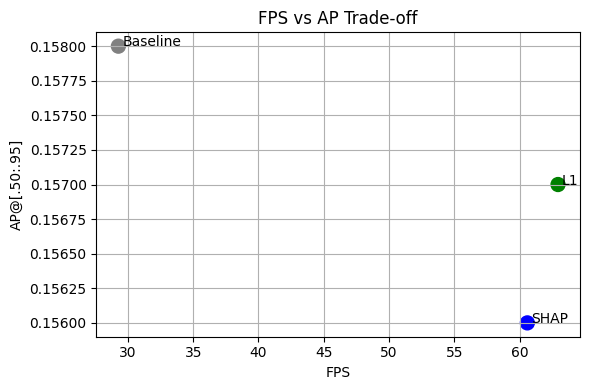

In [24]:
plt.figure(figsize=(6, 4))
plt.scatter([fps_baseline, fps_shap, fps_l1], [0.158, 0.156, 0.157], s=100, c=['gray', 'blue', 'green'])
for name, fps, ap in zip(["Baseline", "SHAP", "L1"], [fps_baseline, fps_shap, fps_l1], [0.158, 0.156, 0.157]):
    plt.text(fps + 0.3, ap, name)
plt.xlabel("FPS")
plt.ylabel("AP@[.50:.95]")
plt.title("FPS vs AP Trade-off")
plt.grid(True)
plt.tight_layout()
plt.show()


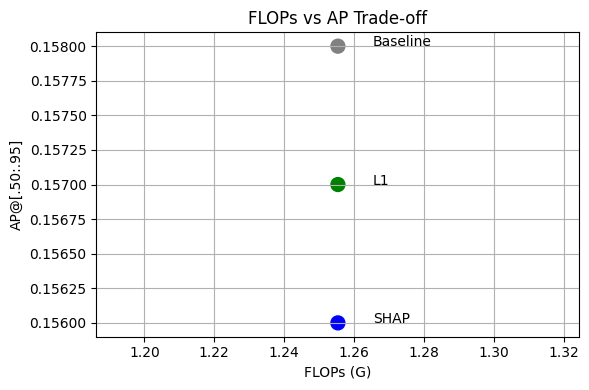

In [25]:
plt.figure(figsize=(6, 4))
plt.scatter([baseline_flops, shap_flops, l1_flops], [0.158, 0.156, 0.157], s=100, c=['gray', 'blue', 'green'])
for name, flops, ap in zip(["Baseline", "SHAP", "L1"], [baseline_flops, shap_flops, l1_flops], [0.158, 0.156, 0.157]):
    plt.text(flops + 0.01, ap, name)
plt.xlabel("FLOPs (G)")
plt.ylabel("AP@[.50:.95]")
plt.title("FLOPs vs AP Trade-off")
plt.grid(True)
plt.tight_layout()
plt.show()
